In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import theano.tensor as tt
import scipy

from packages.analysis.analyze import *

In [5]:
results_frame = load_results_frame_compositional("all_languages_results_2023-01-17_compositional.csv") 
results_frame = add_kwargs_to_frame(results_frame)
results_frame = results_frame[results_frame['data_quantity'] == 'low']


In [6]:
from sklearn import preprocessing
def preprocess_results_frame(frame, language_le, method_class_le):
    frame = frame.copy()
    # assert there are no infinities or negative infinities in result
    # frame.replace([np.inf, -np.inf], np.nan, inplace=True)
    # replace result with a small positive value if it is 0
    frame['result'] = frame['result'].apply(lambda x: 1e-3 if x == 0 else x)
    frame['result_logit'] = frame['result'].apply(scipy.special.logit)
    frame['log_num_aug'] = frame['num_aug'].apply(lambda x: np.log2(x/64) if x != 0 else 0)
    # check if there are nan values in method_class_i, result_logit, log_num_aug, language_i
    frame['language_i'] = language_le.transform(frame['language'])
    frame['method_class_i'] = method_class_le.transform(frame['method_class'])
    print(frame[['method_class_i', 'result_logit', 'log_num_aug', 'language_i']].isnull().values.any())

    return frame
language_le = preprocessing.LabelEncoder()
language_le.fit(results_frame['language'])
method_class_le = preprocessing.LabelEncoder()
method_class_le.fit(results_frame['method_class'])
preproc_frame = preprocess_results_frame(results_frame, language_le, method_class_le)


False


In [7]:
model = pm.Model()
with model:
    # create pm.Data called method_class, containing method_class_i from preproc_frame
    method_class = pm.Data('method_class', preproc_frame['method_class_i'])
    language = pm.Data('language', preproc_frame['language_i'])
    log_num_aug = pm.Data('log_num_aug', preproc_frame['log_num_aug'])

    sigma_parameter = pm.HalfNormal('model_err', sigma=1) 
    
    bias_parameter = pm.Normal('bias', 0, sigma=1, shape=(1,))
    mu_method_class_parameter = pm.Normal('mu_method_class', 0, sigma=1, shape=(len(preproc_frame['method_class_i'].unique()),))
    mu_language_parameter = pm.Normal('mu_language', 0, sigma=1, shape=(len(preproc_frame['language_i'].unique()),))
    mu_log_num_aug_parameter = pm.Normal('mu_log_num_aug', 0, sigma=1, shape=(1,))

    # expected value
    logit_acc_est = bias_parameter + mu_method_class_parameter[method_class] + mu_language_parameter[language] + mu_log_num_aug_parameter * log_num_aug 
    logit_acc_likelihood = pm.Normal('y_like', logit_acc_est, sigma= sigma_parameter, observed=preproc_frame['result_logit']) # TODO: add the logit transformed.

    trace = pm.sample(2000, tune=1000, cores=2, chains=2)
        


/tmp/ipykernel_1674/572955635.py:19: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, tune=1000, cores=2, chains=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log_num_aug, mu_language, mu_method_class, bias, model_err]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 91 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


/tmp/ipykernel_1674/159587787.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
Got error No model on context stack. trying to find log_likelihood in translation.
/home/samir/miniconda3/envs/pm3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'bias'}>,
        <AxesSubplot:title={'center':'bias'}>],
       [<AxesSubplot:title={'center':'mu_method_class'}>,
        <AxesSubplot:title={'center':'mu_method_class'}>],
       [<AxesSubplot:title={'center':'mu_language'}>,
        <AxesSubplot:title={'center':'mu_language'}>],
       [<AxesSubplot:title={'center':'mu_log_num_aug'}>,
        <AxesSubplot:title={'center':'mu_log_num_aug'}>],
       [<AxesSubplot:title={'center':'model_err'}>,
        <AxesSubplot:title={'center':'model_err'}>]], dtype=object)

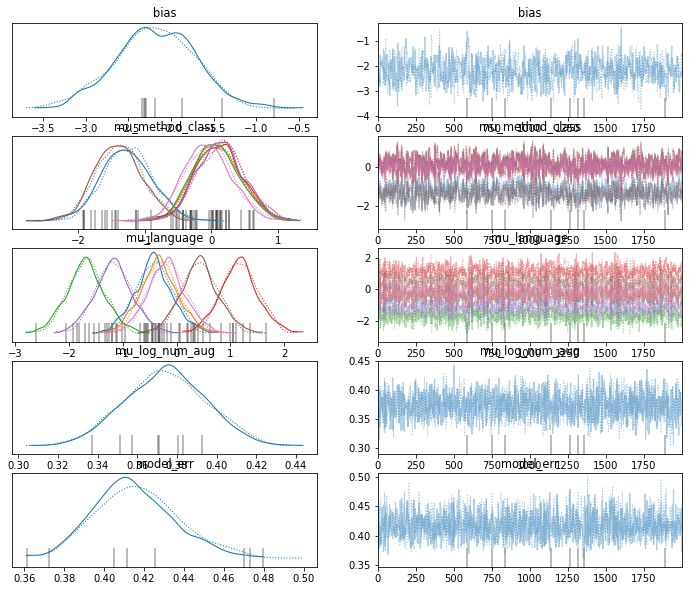

In [8]:
# plot the trace
pm.traceplot(trace)


{'initial': -1.255459911207623, 'random': 0.10473602318960754, 'uat_use_empirical=False_use_loss=False': 0.0820379227798872, 'uat_use_empirical=False_use_loss=True': 0.13733450630176236, 'uat_use_empirical=True_use_loss=True': 0.158154596833113, 'uncertainty_use_high_loss=False': -1.3755660977422883, 'uncertainty_use_high_loss=True': -0.03592867306321475}
(4000, 7)


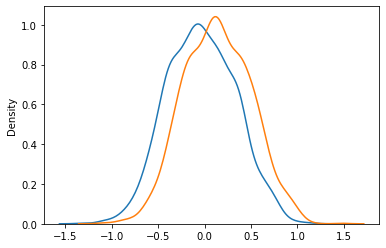

In [7]:
# Obtain the means of mu_method_class, averaging across the first chain of the trace. Put them in a dictionary with the keys being the method_class names from the method class 

method_class_samples = {}
for i, method_class in enumerate(method_class_le.classes_):
    method_class_samples[method_class] = trace['mu_method_class'][:2000,i]

# create a dictionary with the means of the method_class_samples
method_class_means = {}
for i, method_class in enumerate(method_class_le.classes_):
    method_class_means[method_class] = method_class_samples[method_class].mean(axis=0)


# get the difference between the method_class_means['random'] and method_class_means['uat_use_empirical=False_use_loss=True'] 
# and plot the distribution of the difference
print(method_class_means)
sns.kdeplot(method_class_samples['uncertainty_use_high_loss=True'], label='uncertainty_use_high_loss=True')
sns.kdeplot(method_class_samples['uat_use_empirical=False_use_loss=True'], label='uat_use_empirical=False_use_loss=True')
print(trace['mu_method_class'].shape)


In [197]:
# def simulate_results(method_class, num_aug, language, 
#                      posterior_trace_chain, num_samples_per_chain):
#     """Generate {num_samples_per_chain} samples for the given method_class, num_aug, language combination.

#     Args:
#         method_class (str): Method used for augmentation.
#         num_aug (int): Number of augmented datapoints
#         language (str): Language of the dataset
#         posterior_trace_chain (dict): Dictionary with the posterior trace chain, mapping parameter names to numpy arrays. 
#     """
#     # create a dataframe with columns method_class, num_aug, language and a single row with the values of the arguments
#     df = pd.DataFrame({'method_class': [method_class], 'num_aug': [num_aug], 
#                        'language': [language], 'result': [0.5]}) # result is not used in the simulation
#     preproc_df = preprocess_results_frame(df, language_le, method_class_le)
#     posterior_simulation_mus = posterior_trace_chain['mu_method_class'][:num_samples_per_chain,preproc_df['method_class_i'].values[0]] + posterior_trace_chain['mu_language'][:num_samples_per_chain,preproc_df['language_i'].values[0]] + (posterior_trace_chain['mu_log_num_aug'][:num_samples_per_chain,:] * preproc_df['log_num_aug'].values[0])[:,0]
#     # print(posterior_trace_chain['mu_method_class'][:,preproc_df['method_class_i'].values[0]].shape)
#     # print((posterior_trace_chain['mu_log_num_aug'] * preproc_df['log_num_aug'].values[0])[:,0].shape)
#     posterior_simulations = pm.Normal.dist(mu=posterior_simulation_mus, sigma= posterior_trace_chain['model_err'][:num_samples_per_chain]).random(size=num_samples_per_chain)

#     print(posterior_simulation_mus.shape)
#     return posterior_simulations
#     # return posterior_simulations
# samples = simulate_results('uat_use_empirical=False_use_loss=True', 256, 'bengali', trace, 2000)
# # apply the inverse logit transformation to the samples.
# samples = 1 / (1 + np.exp(-samples))
# sns.kdeplot(samples, label='uat_use_empirical=False_use_loss=True')

y_pred = pm.sample_posterior_predictive(trace, samples=4000, model=model, )

In [202]:
preproc_frame.head()

,method,result,num_eval_datapoints,language,num_aug,method_class,data_quantity,valid,result_logit,log_num_aug,language_i,method_class_i
1.0,uncertainty_sample_num_aug=2048_r=1.0_train_me...,0.163,1000,bengali,2048,uncertainty_use_high_loss=False,low,True,-1.636074,5.0,1,5
6.0,uat_num_aug=512_train_medium=False_use_empiric...,0.237,1000,bengali,512,uat_use_empirical=False_use_loss=True,low,True,-1.169198,3.0,1,3
7.0,uncertainty_sample_num_aug=256_r=1.0_train_med...,0.212,1000,bengali,256,uncertainty_use_high_loss=True,low,True,-1.312912,2.0,1,6
9.0,uncertainty_sample_num_aug=512_r=1.0_train_med...,0.238,1000,bengali,512,uncertainty_use_high_loss=True,low,True,-1.163676,3.0,1,6
13.0,random_num_aug=256_train_medium=False,0.146,1000,bengali,256,random,low,True,-1.766325,2.0,1,1


False


(4000, 2)
0.2318138379818628
0.21995636135768415


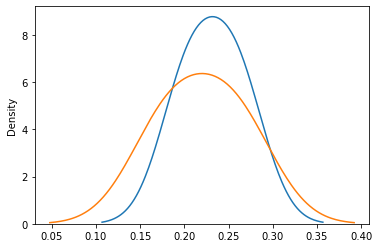

In [13]:
with model:
    # set data for pymc3 so that the language is bengali, the number of augmented points is 256 and the method_class is uat_use_empirical=False_use_loss=True. Put these values in a dataframe first and then preprocess them, before passing them to the model.
    df = pd.DataFrame({'method_class': ['uat_use_empirical=False_use_loss=True', 'random'], 'num_aug': [256, 256],
                          'language': ['arabic', 'arabic'], 'result': [0.5, 0.5]}) # result is not used in the simulation
    preproc_df_test = preprocess_results_frame(df, language_le, method_class_le)
    # preproc_df_test = pd.concat([preproc_df_test]*10, ignore_index=True)
    # use pm.set_data to set the method_class, language and log_num_aug values according to the dataframe. Keep the data wrapped in a numpy array
    pm.set_data({'method_class': preproc_df_test['method_class_i'], 'language': preproc_df_test['language_i'], 'log_num_aug': preproc_df_test['log_num_aug']})
    # sample from the posterior predictive distribution
    y_pred = pm.sample_posterior_predictive(trace, samples=4000, random_seed=42)

print(y_pred['y_like'].shape)
# plot the first row of y_pred['y_like'] after applying the inverse logit transformation
sns.kdeplot(1 / (1 + np.exp(-y_pred['y_like'][0,:])), label='uat_use_empirical=False_use_loss=True')
# do the same for the second row
sns.kdeplot(1 / (1 + np.exp(-y_pred['y_like'][1,:])), label='random')

# print the average of the first row of y_pred['y_like'] after applying the inverse logit transformation
print(np.mean(1 / (1 + np.exp(-y_pred['y_like'][0,:]))))
print(np.mean(1 / (1 + np.exp(-y_pred['y_like'][1,:]))))